# Imports

In [2595]:
import time
import random
import osmnx as ox # OSMnx library for street networks using OpenStreetMap data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"

# Create graph

In [2596]:
start_coords = (53.472075, -2.238855)

In [2597]:
# Get data from open street maps and plot network
 
# See if data is already in cache to save time when running in notebooks.
try:
    G
except NameError:
    G = ox.graph_from_point(start_coords, dist=2000, network_type="drive", simplify=True)

In [2598]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# General Node Class

In [2599]:
class Node():
    def __init__(self, node_id, cost_to_reach=np.nan, parent=None):
        self.node_id = node_id
        self.path_to_node = []
        self.cost_to_reach = cost_to_reach
        
        self.parent = parent

    def path_to(self):
        if self.parent is None: return []
        
        return self.parent.path_to() + [self.node_id]
                
    def __str__(self):
        return f"<class Node Object>, ID: {self.node_id}"
    
    def __repr__(self):
        return f"({self.__str__()})"
    
    def __eq__(self, other):
        # Compare equality based on the node_id
        if isinstance(other, Node):
            return self.node_id == other.node_id
        return False

    def __hash__(self):
        return hash(self.node_id)

# Setup

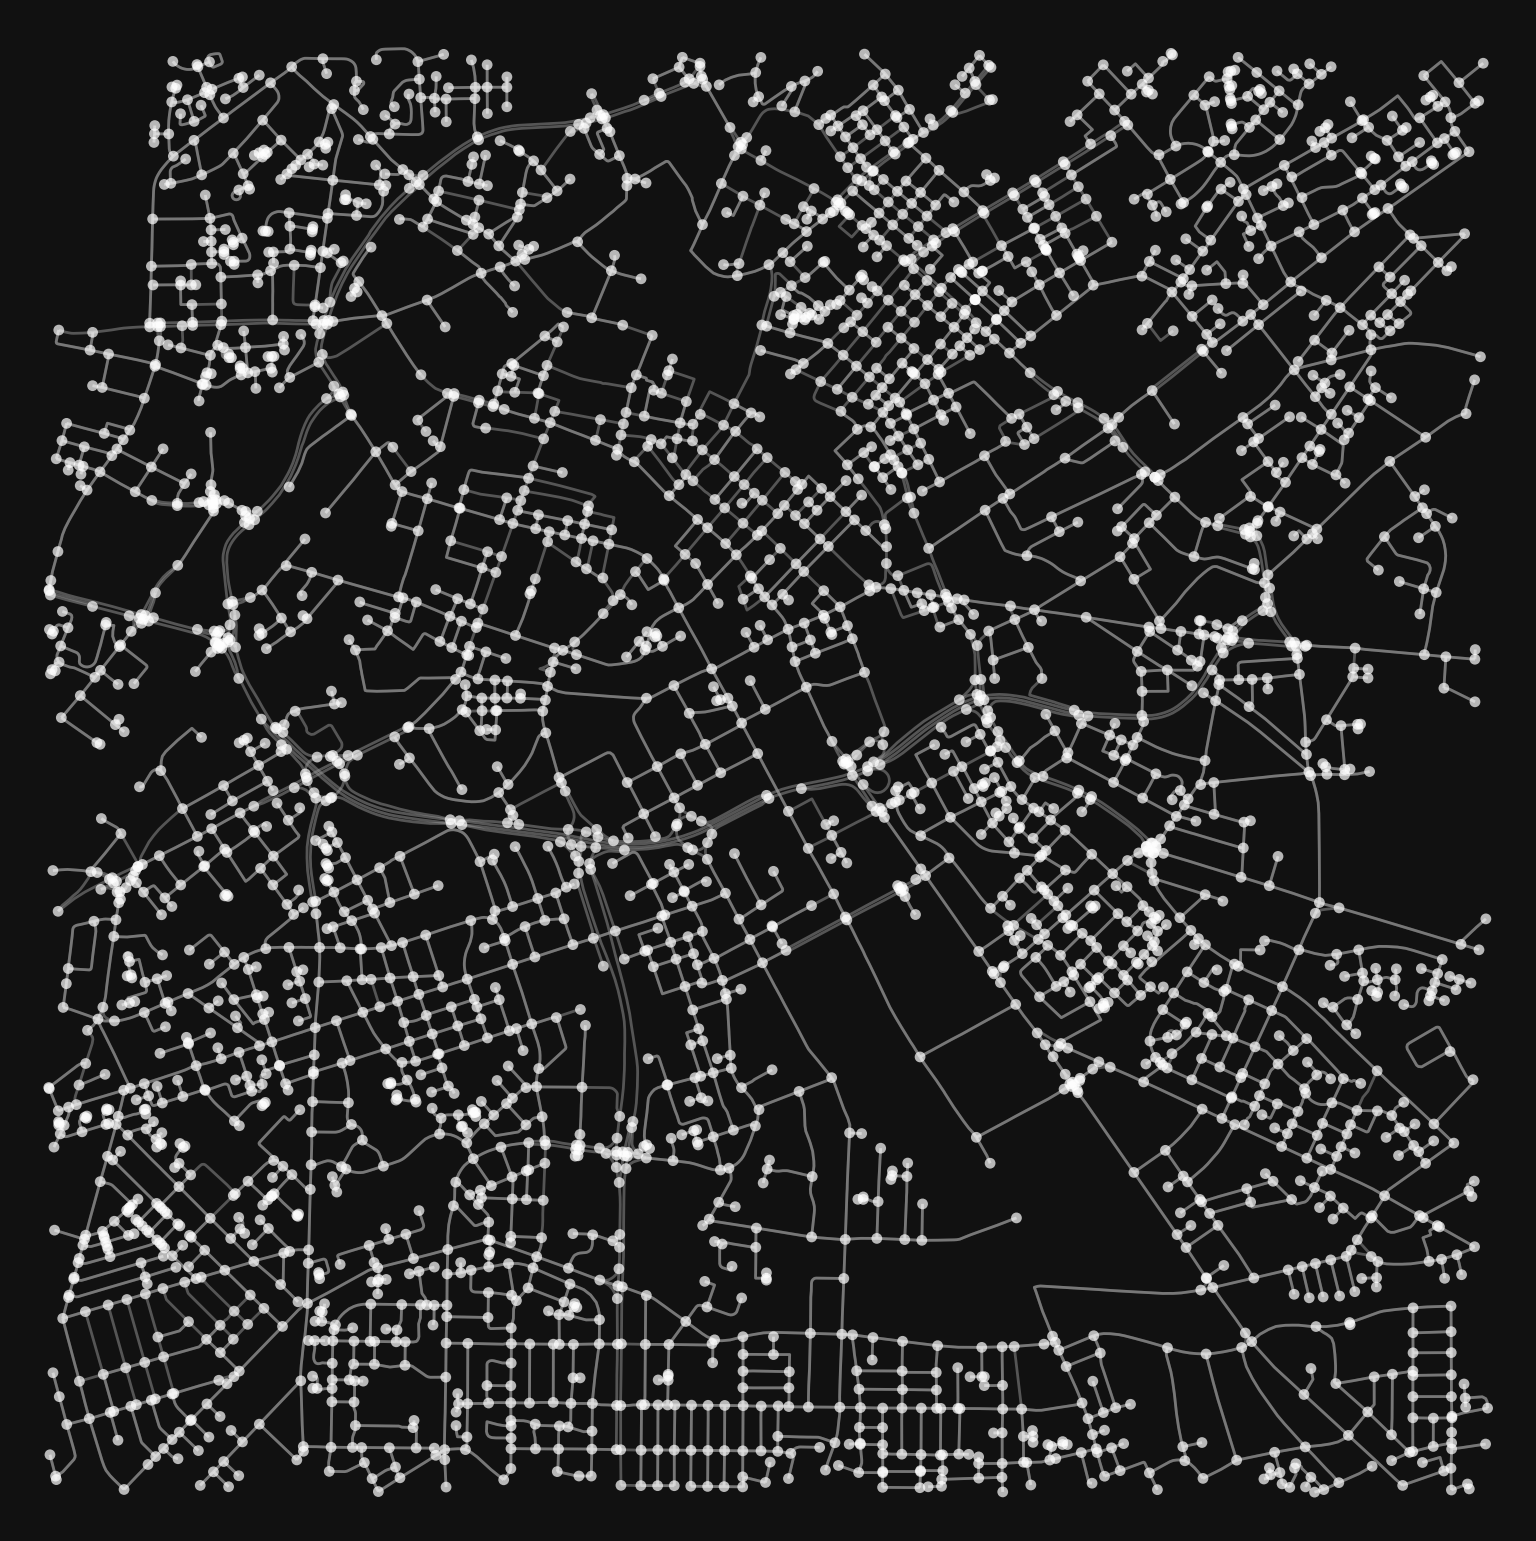

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 8),facecolor="#111111");
ax.set_facecolor("#111111")

# Remove margins
ax.margins(0)
plt.tight_layout(pad=0)

fig, ax, scatter = ox.plot_graph(G, ax=ax, node_alpha=0.7, edge_alpha=0.5);

In [2601]:
# Create list of nodes
nodes = [Node(node_id) for node_id in G.nodes()]

In [2602]:
num_points = len(nodes)

# Create a dictionary of adjacent node for look-up.
adj_dict = {n: list(adjacent_node_dict.keys()) for n, adjacent_node_dict in G.adjacency()}

# Visualising

In [2603]:
# Create a dictionary to map nodes to their index in a list
node_index_map = {nodes[i]: i for i in range(num_points)}

def update_graph_visuals(current_node, closed_set, destination_node):
    '''
    Function to update the sizes and colours of the nodes in the graph.
    '''
    sizes = [10 for i in range(num_points)]
    colours = ["#FFFFFF" for i in range(num_points)] 
    
    # Loop through all closed (visited) nodes and set them to yellow and size 10
    for node in closed_set:
        sizes[node_index_map[node]] = 10
        colours[node_index_map[node]] = "#FFFF00"

    # Set destination node to size 30 and to purple colour 
    colours[node_index_map[destination_node]] = "#FF00FF"
    sizes[node_index_map[destination_node]] = 30
    
    # Set the current node to size 50 and to red colour
    sizes[node_index_map[current_node]] = 50
    colours[node_index_map[current_node]] = "#FF0000"
    
    # Update the sizes and colours of the nodes in the scatter plot.
    scatter.set_sizes(sizes)
    scatter.set_color(colours)

    return scatter

# Searching

In [2604]:
from sklearn.impute import SimpleImputer

def handle_maxspeed(value):
    if isinstance(value, list):  # Check if the value is a list
        return (float(value[0][:-3]) + float(value[1][:-3])) / 2
    if isinstance(value, str):
        return int(value[:-3])
    return value

# Apply the function to the "maxspeed" column
gdf_edges["maxspeed"] = gdf_edges["maxspeed"].apply(handle_maxspeed)

imputer = SimpleImputer()
gdf_edges[["maxspeed"]] = imputer.fit_transform(gdf_edges[["maxspeed"]])

In [2605]:
def mph_to_mps(speed_mph):
    return (speed_mph * 1609.344) / 60**2

def time_between(start_node_id, end_node_id):
    try:
        speed = gdf_edges.xs(start_node_id, level="u").xs(end_node_id, level="v")["maxspeed"][0].item()
    except ValueError:
        print(start_node_id, end_node_id)
        raise Exception(gdf_edges.xs(start_node_id, level="u").xs(end_node_id, level="v")["maxspeed"])
    
    distance = gdf_edges.xs(start_node_id, level="u").xs(end_node_id, level="v")["length"][0].item()

    # With speed in m/s and distance in m this returns the time between nodes in s
    return distance / mph_to_mps(speed) 

def format_time(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [2607]:
class SearchClass:
    def __init__(self, start_node, destination_node, heuristic_func=None):
        self.start = start_node
        self.destination = destination_node
        self.done = False

        self.open = [start_node]
        self.closed = []

        self.current_node = start_node

        self.heuristic_dict = {start_node: heuristic_func(start_node, destination_node)} if heuristic_func is not None else {}
        self.heuristic_func = heuristic_func

    def reset(self):
        self.closed = []
        self.done = False
        self.heuristic_dict = {self.start: self.heuristic_func(self.start, self.destination)} if self.heuristic_func is not None else {}
        self.open = [self.start]
        self.current_node = self.start

    def run_search(self, search_type):
        while not self.done:
            self.search_step(search_type=search_type)

    def search_step(self, search_type):       
        next_node = self.pick_node(search_type)
        if self.heuristic_func is not None: self.heuristic_dict[next_node] = self.heuristic_func(next_node, self.destination)
        self.done = (next_node == self.destination)
        self.open.extend([Node(node_id, parent=next_node) for node_id in adj_dict[next_node.node_id] if Node(node_id) not in self.closed])
        self.closed.append(next_node)
        self.current_node = next_node

        return next_node
    
    def pick_node(self, search_type):
        if search_type == "dfs":
            return self.open.pop(-1)
        if search_type == "bfs":
            return self.open.pop(0)
        if search_type == "a_star":
            self.open.sort(key=lambda node: self.heuristic_dict[node] if node in self.heuristic_dict.keys() else self.heuristic_func(node, self.destination))
            return self.open.pop(0)
        
    def calc_path_time(self, path):
        time = 0
        for i in range(len(path) - 1):
            time += time_between(path[i], path[i+1])
        return time
    
    def describe_path(self, path):
        path_list = []
        for i in range(len(path) - 1):
            path_list.append(str(gdf_edges.xs(path[i], level="u").xs(path[i + 1], level="v")["name"].item()))
        return pd.Series(path_list).unique()

In [2608]:
# Visualisation code

class SearchClass(SearchClass):
    def animate_search(self, search_type):
        # Animation function
        def animate(frame):
            next_node = self.search_step(search_type)
            update_graph_visuals(next_node, self.closed, self.destination)
            return scatter
        
        # Frame generator: Stops yielding when .done
        def frame_generator():
            frame = 0
            while not self.done:
                yield frame
                frame += 1

        # Create the animation using the generator
        ani = animation.FuncAnimation(fig, animate, frames=frame_generator, interval=1, save_count=num_points)

        # Save the animation
        ffmpeg_writer = animation.FFMpegWriter(fps=5)
        print(f"Saving output to {search_type + "_manchester.mp4"}.")
        ani.save(search_type + "_manchester.mp4", writer=ffmpeg_writer)

    def display_final(self):
        if len(self.closed) <= 0:
            raise Exception("Must execute run_search method before displaying.")
        
        path = self.closed[-1].path_to()
        print("Final path:", self.describe_path(path))
        print("Path traversal time:", format_time(self.calc_path_time(path)))
    
        # Get node coordinates from the graph
        node_x = [G.nodes[node.node_id]['x'] for node in nodes]
        node_y = [G.nodes[node.node_id]['y'] for node in nodes]

        # Set default sizes and colors
        sizes = [5 for _ in range(num_points)]
        colours = ["#DDDDDD" for _ in range(num_points)] 

        # Extract start and destination node positions
        start_x, start_y = G.nodes[self.start.node_id]['x'], G.nodes[self.start.node_id]['y']
        dest_x, dest_y = G.nodes[self.destination.node_id]['x'], G.nodes[self.destination.node_id]['y']

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(7, 7), facecolor="#111111")
        ax.set_facecolor("#111111")
        ax.axis('off')

        # Plot all edges (graph edges) in grey
        for u, v, data in G.edges(data=True):
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#777777", alpha=1, lw=1, zorder=1)

        # Highlight path edges
        full_path = [self.start.node_id] + path  # Include start node explicitly
        for i in range(len(full_path) - 1):  # Iterate through consecutive nodes in the path
            u, v = full_path[i], full_path[i + 1]
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#FFFF00", lw=2.5, alpha=1, zorder=3)  # Highlighted path edges

        # Plot all other nodes with default sizes and colors
        ax.scatter(node_x, node_y, s=sizes, c=colours, zorder=2)

        # Plot nodes on the path
        for node_id in path:
            x, y = G.nodes[node_id]['x'], G.nodes[node_id]['y']
            ax.scatter(x, y, s=8, c="#FFFF00", zorder=4)

        # Plot the start node on top (in red)
        ax.scatter(start_x, start_y, s=50, c="#FF0000", label="Start", zorder=5)

        # Plot the destination node on top (in purple)
        ax.scatter(dest_x, dest_y, s=50, c="#FF00FF", label="Destination", zorder=5)

        # Add legend for clarity (optional)
        ax.legend(facecolor="#222222", labelcolor="#FFFFFF", loc="upper right")

        plt.show()

# Heuristics

In [2609]:
def euclid_distance(start_node, end_node):
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    return ((x_start - x_end)**2 + (y_start - y_end)**2)**0.5

def manhattan_distance(start_node, end_node):
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    return abs(x_start - x_end) + abs(y_start - y_end)

# Running

In [2610]:
# Start at the Dalton Building
start_node = Node(ox.distance.nearest_nodes(G, Y=start_coords[0], X=start_coords[1]), cost_to_reach=0)

# Destination
destination_node = random.choice(nodes)

Final path: ['Chester Street' 'Cambridge Street' 'Cambridge Street Junction'
 'Mancunian Way' 'Fairfield Street' 'Pin Mill Brow' 'Chancellor Lane'
 'Midland Street' 'Handsworth Street']
Path traversal time: 00:03:17


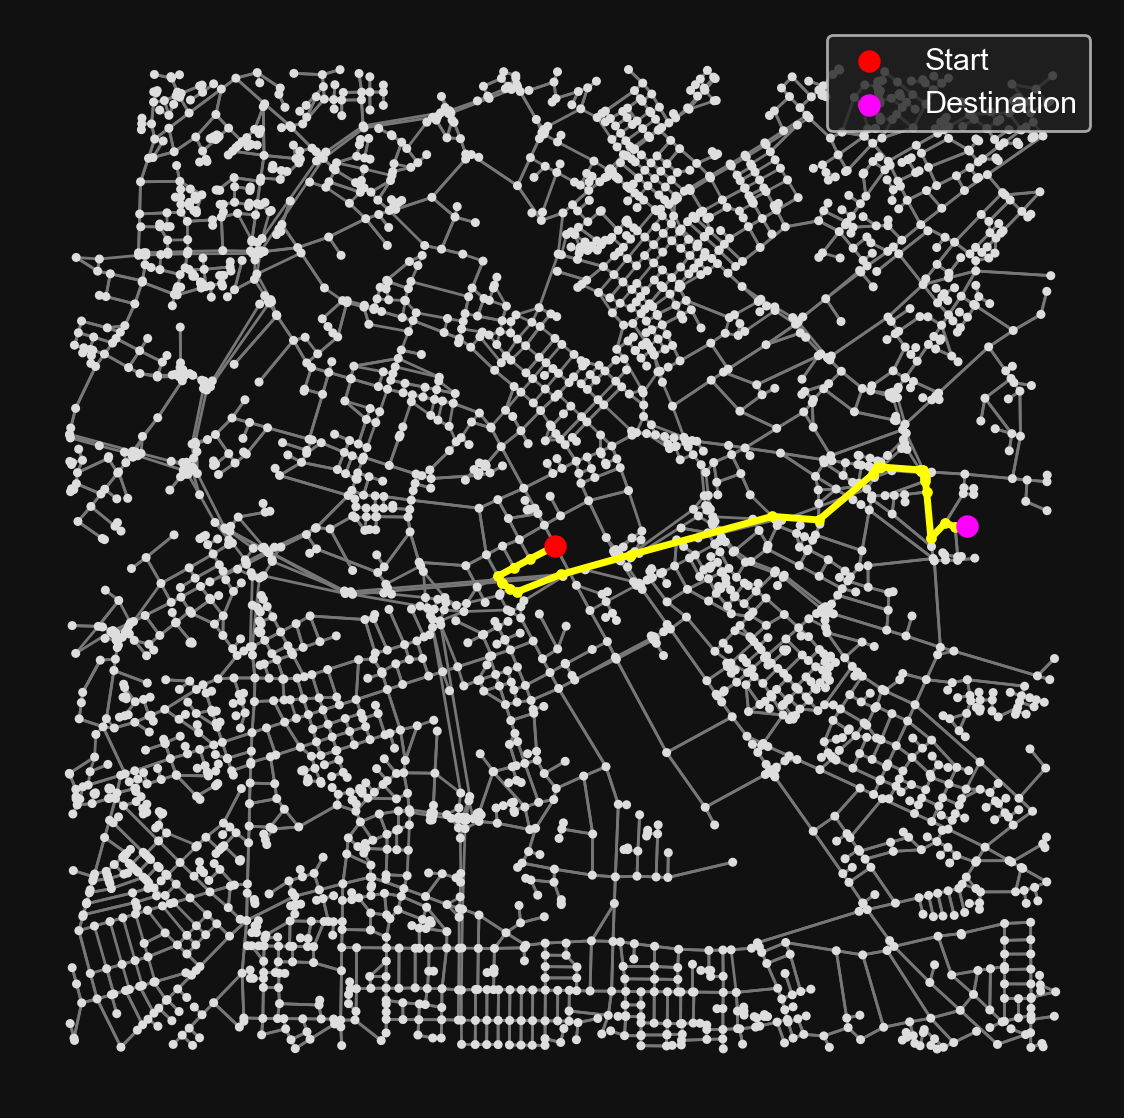

Final path: ['Charles Street' 'Princess Street' 'Brook Street' 'Sackville Street'
 'Upper Brook Street' 'Inchley Road' 'Kincardine Road' 'Balsam Close'
 'Rudcroft Close' 'Hartfield Close' 'Buttercup Street'
 'Sylvia Pankhurst Way' 'Wadeson Road' 'Brunswick Street' 'nan'
 'Higher Ardwick' 'Dolphin Street' 'Dalberg Street' 'Harkness Street'
 'Palfrey Place' "['Chancellor Lane', 'Devonshire Street North']"
 'Chancellor Lane' 'Midland Street' 'Handsworth Street']
Path traversal time: 00:04:24


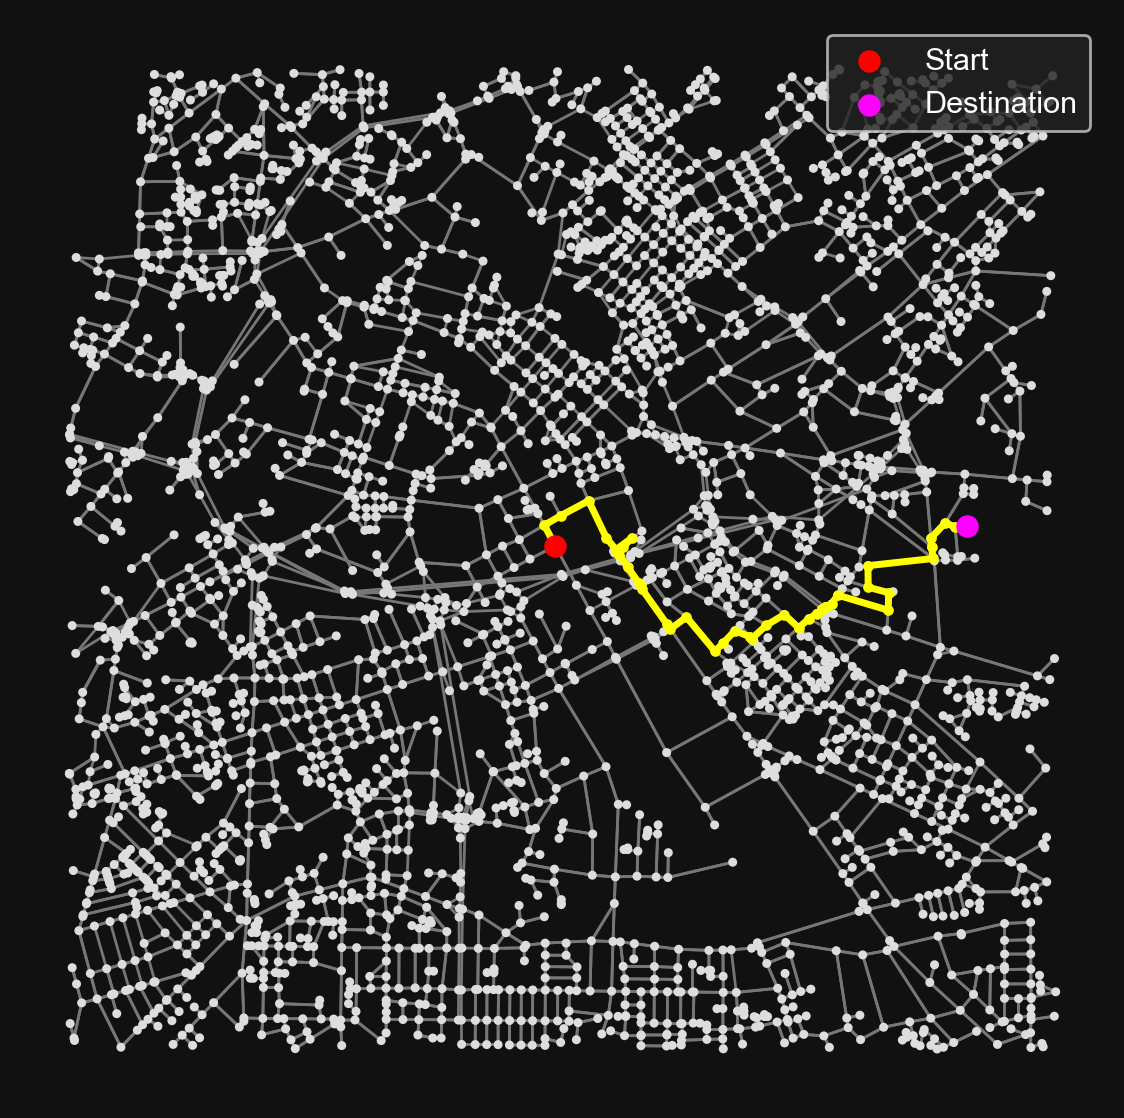

In [2611]:
searcher = SearchClass(start_node, destination_node, heuristic_func=manhattan_distance)

searcher.run_search(search_type="bfs")
searcher.display_final()

searcher.reset()
searcher.run_search(search_type="a_star")
searcher.display_final()

In [2612]:
# searcher.reset()
# searcher.animate_search(search_type="bfs")
# searcher.reset()
# searcher.animate_search(search_type="dfs")
# searcher.reset()
# searcher.animate_search(search_type="a_star")

<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>Breadth First
        <br>
        <video src="bfs_manchester.mp4" alt="bfs" width="501" controls/>
    </div>

  <div style="flex: 50%;">
        <h1>Depth First
        <br>
        <video src="dfs_manchester.mp4" alt="dfs" width="501" controls/>
    </div>
</div>

<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>UCS
        <br>
        <video src="none.mp4" alt="bfs" width="500" controls/>
    </div>

  <div style="flex: 50%;">
        <h1>A*
        <br>
        <video src="a_star_manchester.mp4" alt="dfs" width="501" controls/>
    </div>
</div>

# Evaluation

In [2613]:
from pretty_progress import progress_bar

n_trials = 100

results_df = pd.DataFrame({
    "Distance": np.zeros(n_trials),
    "DFS_Time": np.zeros(n_trials),
    "BFS_Time": np.zeros(n_trials),
    "A_Star_Time": np.zeros(n_trials),
    "DFS_Journey_Time": np.zeros(n_trials),
    "BFS_Journey_Time": np.zeros(n_trials),
    "A_Star_Journey_Time": np.zeros(n_trials),
})

# Run the search n times
for i in range(n_trials):
    progress_bar(i, n_trials)

    start = start_node
    end = random.choice(nodes)

    searcher = SearchClass(start_node, end, heuristic_func=manhattan_distance)

    start_time = time.time_ns()
    searcher.run_search(search_type="bfs")
    bfs_duration =  time.time_ns() - start_time
    bfs_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    searcher.reset()
    start_time = time.time_ns()
    searcher.run_search(search_type="dfs")
    dfs_duration = time.time_ns() - start_time
    dfs_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    searcher.reset()
    start_time = time.time_ns()
    searcher.run_search(search_type="a_star")
    a_star_duration = time.time_ns() - start_time
    a_star_journey_time = searcher.calc_path_time(searcher.closed[-1].path_to())

    # Fill row
    results_df.loc[i] = [euclid_distance(start, end), dfs_duration / 1e6, bfs_duration / 1e6, a_star_duration / 1e6, dfs_journey_time, bfs_journey_time, a_star_journey_time]

|#################################################-| 99%
Done!


In [2635]:
results_df.describe()

,Distance,DFS_Time,BFS_Time,A_Star_Time,DFS_Journey_Time,BFS_Journey_Time,A_Star_Journey_Time
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.018089,462.781360,10828.482280,1.879830,3249.763389,220.862901,229.870679
std,0.007323,496.799273,11892.253227,2.004591,1371.150590,92.637080,97.243599
min,0.001934,0.008000,0.027000,0.013000,0.000000,0.000000,0.000000
25%,0.012924,39.848250,327.967500,0.557000,2124.941689,166.745151,151.795656
50%,0.017577,312.841000,6647.809000,1.145000,3703.763577,219.327128,246.964052
75%,0.023938,776.087250,20910.708250,2.402500,4419.443959,279.896577,298.408518
max,0.034580,2035.562000,37663.024000,9.450000,4840.833138,423.304324,449.814293


In [2634]:
results_df.describe()[["DFS_Time", "BFS_Time", "A_Star_Time"]].loc["mean"]

DFS_Time         462.78136
BFS_Time       10828.48228
A_Star_Time        1.87983
Name: mean, dtype: float64

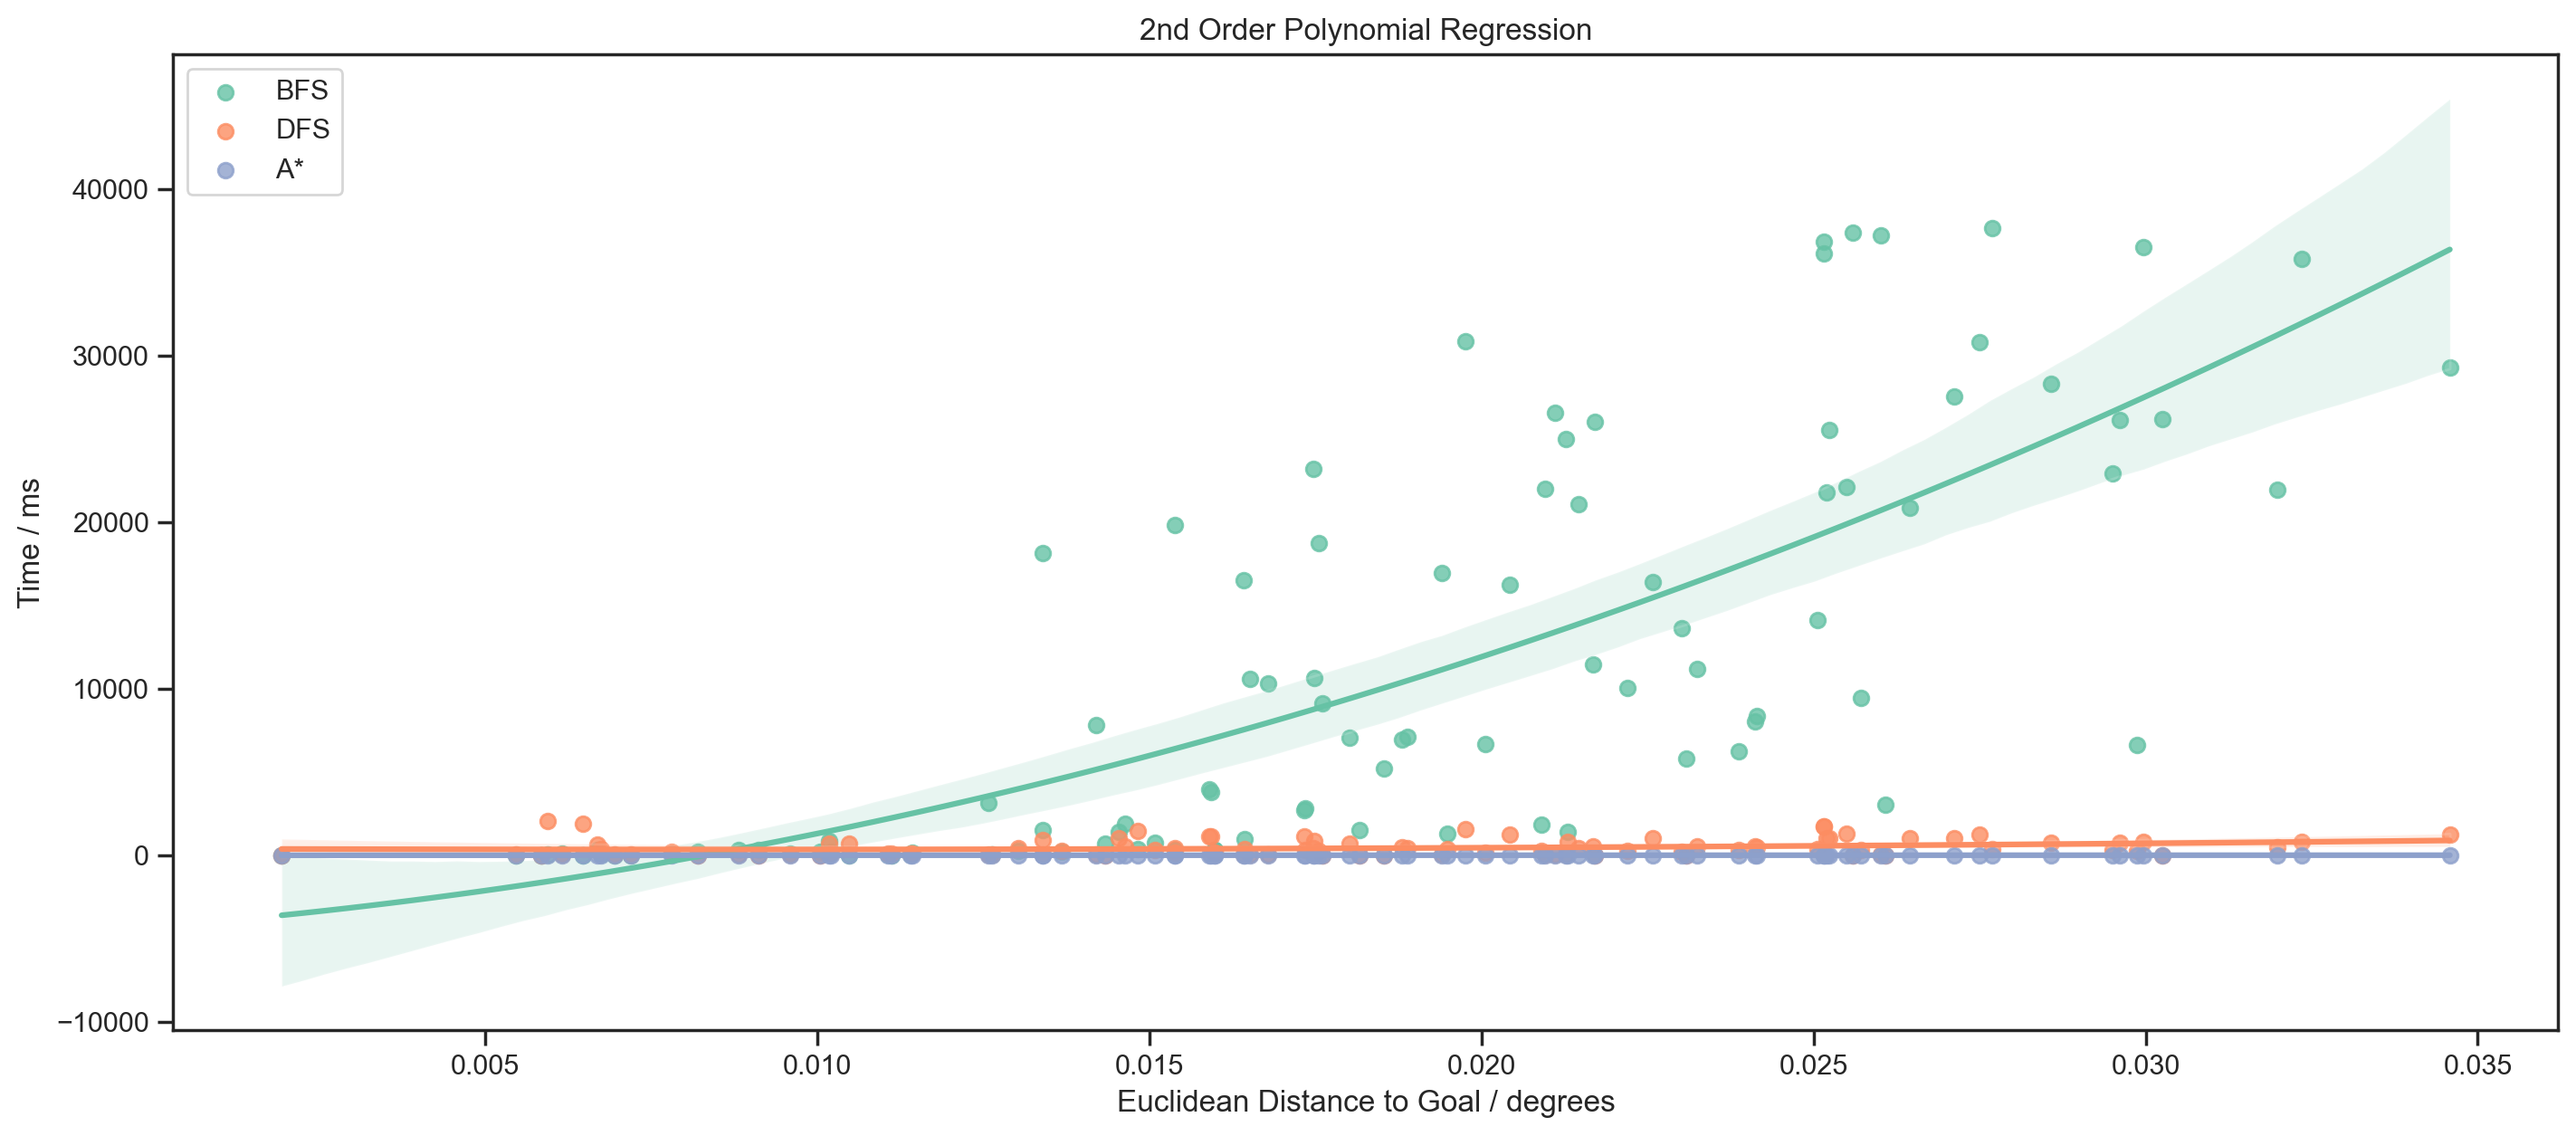

In [2622]:
sns.regplot(results_df, x="Distance", y="BFS_Time", order=2, ci=95, label="BFS")
sns.regplot(results_df, x="Distance", y="DFS_Time", order=2, ci=95, label="DFS")
sns.regplot(results_df, x="Distance", y="A_Star_Time", order=2, ci=95, label="A*")

# Customize the plot
plt.xlabel("Euclidean Distance to Goal / degrees")
plt.ylabel("Time / ms")
plt.title("2nd Order Polynomial Regression")
plt.legend()
plt.show()